<a href="https://colab.research.google.com/github/ola-sam/ResNET50/blob/main/ResNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a notebook for my Residual Network (ResNET50) reference on collab. ResNet50 is a powerful model for image classification when it's trained for an adequate number of iterations. It can be used to perform state-of-the-art classification accuracy.

**Notes**:

- Very deep "plain" networks don't work in practice because vanishing gradients make them hard to train.  
- Skip connections help address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function.
- There are two main types of blocks: The **identity block** and the **convolutional block**.
- Very deep Residual Networks are built by stacking these blocks together.

The purpose of this project is to use ResNET to classify/recognize Signs

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
# from resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow


# from test_utils import summary, comparator
# import public_tests

%matplotlib inline
np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
# Other functions and Packages. (Can be created as an utils.py)
import os
import numpy as np
import tensorflow as tf
import h5py
import math

from keras.layers import Layer

class BatchNormalization(Layer):
    def __init__(self,
                 axis=-1,
                 momentum=0.90,
                 name=None,
                 synchronized=False,
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.axis = axis
        self.momentum = momentum

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="beta",
            shape=(input_shape[self.axis]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="gamma",
            shape=(input_shape[self.axis]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="moving_mean",
            shape=(input_shape[self.axis]),
            initializer=tf.initializers.zeros,
            trainable=False)

        self.moving_variance = self.add_weight(
            name="moving_variance",
            shape=(input_shape[self.axis]),
            initializer=tf.initializers.ones,
            trainable=False)

    def get_moving_average(self, statistic, new_value):
        momentum = self.momentum
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            assert len(inputs.shape) in (2, 4)
            if len(inputs.shape) > 2:
                axes = [0, 1, 2]
            else:
                axes = [0]
            mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
        x = self.normalise(inputs, mean, var)
        return self.gamma * x + self.beta


def load_dataset():
    # Read train data file
    train_dataset = h5py.File('sample_data/train_signs.h5', "r")
    # train set x features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    # train set y labels
    train_set_y_orig = np.array(
        train_dataset["train_set_y"][:])

    # Read test data file
    test_dataset = h5py.File('sample_data/test_signs.h5', "r")
    # test set x features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    # test set y labels
    test_set_y_orig = np.array(
        test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size: k *
                                  mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size: k *
                                  mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches *
                                  mini_batch_size: m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches *
                                  mini_batch_size: m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    # Numpy Equivalents:
    # Z1 = np.dot(W1, X) + b1
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    # Z2 = np.dot(W2, a1) + b2
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    # Z3 = np.dot(W3,Z2) + b3
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3


def predict(X, parameters):

    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}

    x = tf.placeholder("float", [12288, 1])

    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)

    sess = tf.Session()
    prediction = sess.run(p, feed_dict={x: X})

    return prediction


In [ ]:

# identity_block

def identity_block(X, f, filters, initializer=random_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    ## Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
# creating convolutional_block function

def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Saving the input value for shortcut
    X_shortcut = X

    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Adding shortcut value to main path and passing it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [ ]:
# Create a ResNet50 function (50 layers)

def ResNet50(input_shape = (64, 64, 3), classes = 6, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Defining the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ## Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL
    X =  AveragePooling2D(pool_size=(2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Creating the model
    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
# Compile the model
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Load the dataset [SIGN dataset]

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [ ]:
# Run or fit the model on the dataset.

model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
34/34 [==============================] - 54s 150ms/step - loss: 1.8369 - accuracy: 0.3500
Epoch 2/20
34/34 [==============================] - 3s 84ms/step - loss: 1.1424 - accuracy: 0.5861
Epoch 3/20
34/34 [==============================] - 3s 84ms/step - loss: 0.7661 - accuracy: 0.7222
Epoch 4/20
34/34 [==============================] - 3s 101ms/step - loss: 0.4249 - accuracy: 0.8454
Epoch 5/20
34/34 [==============================] - 3s 83ms/step - loss: 0.2540 - accuracy: 0.9139
Epoch 6/20
34/34 [==============================] - 3s 85ms/step - loss: 0.1935 - accuracy: 0.9324
Epoch 7/20
34/34 [==============================] - 3s 85ms/step - loss: 0.1522 - accuracy: 0.9546
Epoch 8/20
34/34 [==============================] - 3s 95ms/step - loss: 0.0942 - accuracy: 0.9620
Epoch 9/20
34/34 [==============================] - 3s 91ms/step - loss: 0.1186 - accuracy: 0.9630
Epoch 10/20
34/34 [==============================] - 3s 85ms/step - loss: 0.1390 - accuracy: 0.9509
Epoch 

In [ ]:
# Evaluate model
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 32ms/step - loss: 0.6917 - accuracy: 0.8333
Loss = 0.6917493343353271
Test Accuracy = 0.8333333134651184


Testing on personal or other loaded images



Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 25ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[2.9742211e-04 2.3116965e-02 9.5070529e-01 1.8158671e-02 6.1091367e-04
  7.1108444e-03]]
Class: 2


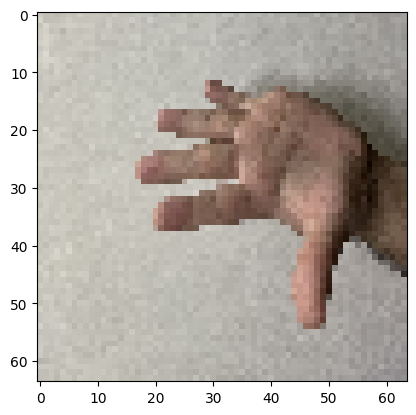

In [ ]:
img_path = 'sample_data/my_image_5.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
x2 = x
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x2)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))

Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 124ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[2.3733701e-06 9.0191889e-01 9.7844683e-02 2.9080813e-05 2.4876892e-05
  1.8000750e-04]]
Class: 1


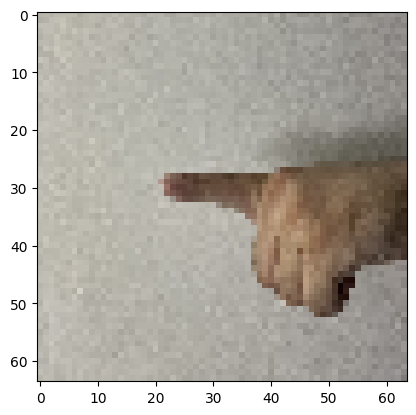

In [ ]:
img_path = 'sample_data/my_image_1.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
x2 = x
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x2)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))

Input image shape: (1, 64, 64, 3)
1/1 [==============================] - 0s 26ms/step
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[7.9275367e-08 3.5858946e-03 9.9525011e-01 1.0284063e-03 9.1741480e-05
  4.3779168e-05]]
Class: 2


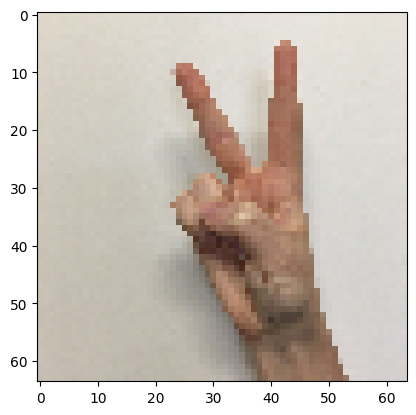

In [ ]:
img_path = 'sample_data/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
x2 = x
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x2)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))

Even though the model has high accuracy, it might be performing poorly on your own set of images. Notice that, the shape of the pictures, the lighting where the photos were taken, and all of the preprocessing steps can have an impact on the performance of the model.